# AMLD-2021-Sketchy: Web App APIs

In this notebook, we reproduce the different API calls of the web app and code along similar functionnalitites.

In [2]:
import base64
import io
import json
import requests

from cairosvg import svg2png
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [ ]:
from src.api.utils import svg_to_png

##  Load an svg string

In the web app the user draws a sketch and then this sketch is sent as an svg string in base 64 to the back-end. Here, we directly load what the back end receives in `svg_string`.

In [46]:
svg_folder = 'svg/'
svg_files = ['amld', 'apple', 'candle']
path = svg_folder + svg_files[0] + '.json' # choose anz

In [47]:
with open(path, 'r') as fp:
    data = json.load(fp)

In [48]:
svg_string = data['sketch']

The function `base64_to_array` converts the base 64 encoded string of an image into a numpy array. 

In [49]:
def base64_to_array(base64_string):
    '''
    Converts a returned base 64 string of an image into a numpy array
    Args: 
        - base64_string: base 64 encoding of the image
    Return:
        - numpy array of the image
    '''
    base64_string = base64_string.split("'")[1]
    image = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(image))
    return np.array(image)

We can convert the string and then plot it.

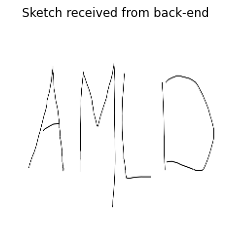

In [50]:
sketch = svg_to_png(svg_string)
plt.imshow(sketch);
plt.title('Sketch received from back-end')
plt.axis("off");

## List of APIs

There are 4 possible api calls. /api_list list them:

In [51]:
res = requests.get("http://127.0.0.1:5000/api_list")
res.json()['available-apis']

[{'api-key': 'cmd: /api_list',
  'description': 'Input: None. Return the list of available commands.'},
 {'api-key': 'cmd: /find_images',
  'description': 'Input: an svg base 64 string of a sketch. Returns base 64 string of its closest images, the associated labels and the attention map'},
 {'api-key': 'cmd: /get_embeddings',
  'description': 'Inputs: a dimension number (2 or 3) and optinally a sketch. Returns the projected points of the embeddings.'},
 {'api-key': 'cmd: /get_dataset_images',
  'description': 'Input: a category name. Returns 5 random images and sketches of this category.'}]

We will code here the functions equivalent to those of the web app.

## Inference: return closest images of sketch

We send an svg drawing to the web app.

In [52]:
data = {"sketch": svg_string}
res = requests.post("http://127.0.0.1:5000/find_images", json=data).json()

In the back-end, the svg is converted into a png and a white background is added. Then the inference function gets the 2 closest images and the associated attention map. These are all returned as a response from the api call.

In [53]:
images_base64 = res['images_base64']
images_labels = res['images_label']
attention = res['attention']

In [54]:
image1 = base64_to_array(images_base64[0])
image2 = base64_to_array(images_base64[1])
attention = base64_to_array(attention)

In [1]:
fig, axes = plt.subplots(1, 4, figsize=(10, 8))
axes[0].set(title='Sketch')
axes[0].imshow(sketch)
axes[0].axis("off");

axes[1].set(title=f'1st image: {images_labels[0]}')
axes[1].imshow(image1)
axes[1].axis("off");

axes[2].set(title=f'2nd image: {images_labels[1]}')
axes[2].imshow(image2)
axes[2].axis("off");

axes[3].set(title=f'Attention map')
axes[3].imshow(attention)
axes[3].axis("off");
plt.subplots_adjust(wspace=0.25, hspace=-0.35)

NameError: name 'plt' is not defined

## Embeddings: get 2D or 3D projection of the embeddings' PCA.

The `/get_embedding` function returns the 2D or 3D PCA projection of a selected number of images embeddings.

- It must receive the number of dimension `nb_dim` that is either 2 or 3 (for 2D or 3D).
- If it receives an svg sketch in `sketch` then it also computes the PCA with this sketch and also return the sketch's projected position in the category "My Custom Sketch".

We show here how to do the 2D plot without sending the custom sketch. 

In [56]:
data = {"nb_dim": 2}
res = requests.post("http://127.0.0.1:5000/get_embeddings", json=data).json()

In [57]:
colors = ["#e6194b","#3cb44b","#ffe119","#4363d8","#f58231",
          "#911eb4","#46f0f0","#f032e6","#bcf60c","#fabebe",
          "#008080","#e6beff","#9a6324","#fffac8","#800000",
          "#aaffc3","#808000","#ffd8b1","#000075","#808080","#000000"]

In [58]:
traces = []
fig = go.Figure()
for i, (category, coordinates) in enumerate(res.items()):
    trace = go.Scatter(
        x=coordinates['x'],
        y=coordinates['y'],
        name=category,
        mode='markers',
        marker_color=colors[i]
    )
    fig.add_trace(trace)
    fig.update_layout(title='2D plot of the embeddings (projected with the PCA)')
    
fig.show()

**TODO**: You can now code the 3D plot with the custom sketch. You can make the Custom Sketch easier to find by customising it.

In [59]:
data = ... # Implement me!
res = ... # Implement me!

In [60]:
traces = []
fig = go.Figure()
# Implement me!
fig.update_layout(title='3D plot of the embeddings (projected with the PCA)')
fig.show()

In [61]:
'''Correction '''
data = {"nb_dim": 3, "sketch": svg_string}
res = requests.post("http://127.0.0.1:5000/get_embeddings", json=data).json()

In [62]:
'''Correction '''
traces = []
fig = go.Figure()
for i, (category, coordinates) in enumerate(res.items()):
    if category == "My Custom Sketch":
        marker_size=8
        line = dict(
            color="#000000",
            width=2
        )
    else:
        marker_size=4
        line=dict()
    trace = go.Scatter3d(
        x=coordinates['x'],
        y=coordinates['y'],
        z=coordinates['z'],
        name=category,
        mode='markers',
        marker=dict(
            size=marker_size,
            color=colors[i],
            line=line
        )
    )
    fig.add_trace(trace)
fig.update_layout(title='3D plot of the embeddings (projected with the PCA)')    
fig.show()

## Dataset: return 5 random images and sketches of a category

The api `/get_dataset_images` takes a category name as json and returns 5 random images and sketch belonging to the category sent as parameter. 
**TODO**: call the api, and plot the resulting sketches and images as in the figure below:

<img src="images/sea-turtle.png">

In [63]:
category = "sea_turtle"
data = {"category": category}
res = ... # Implement me!

In [64]:
# Plot here

In [65]:
''' Correction '''
category = "hedgehog"
data = {"category": category}
res = requests.post("http://127.0.0.1:5000/get_dataset_images", json=data).json()

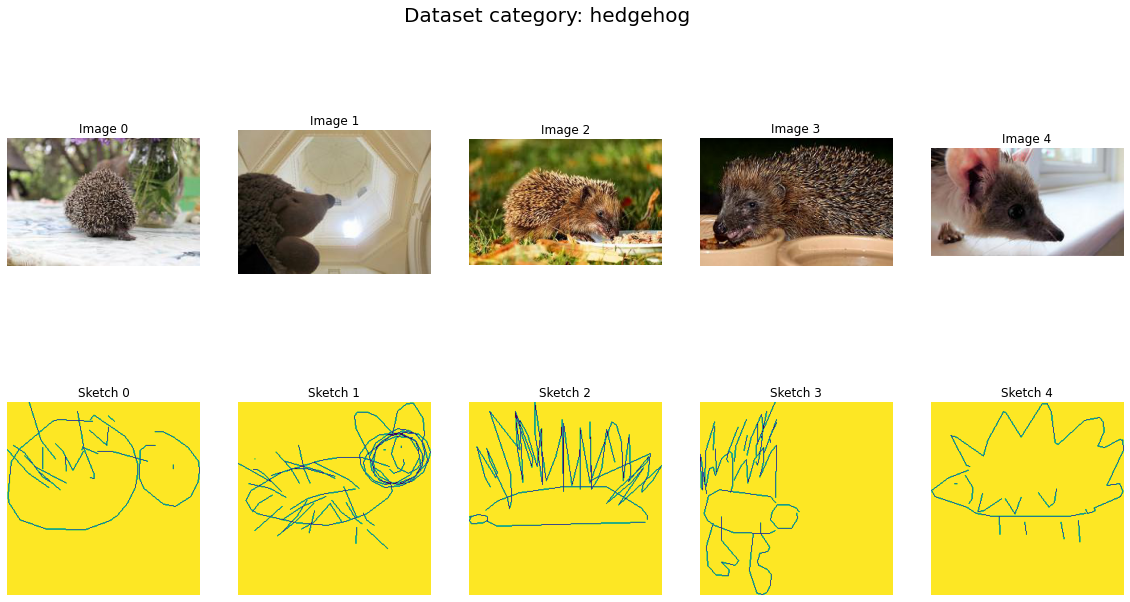

In [66]:
''' Correction '''
images, sketches = [], []

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle(f'Dataset category: {category}', fontsize=20)
for i in range(5):
    sketch = res[f'sketches_{i}_base64']
    image = res[f'images_{i}_base64']
    image = base64_to_array(image)
    sketch = base64_to_array(sketch)
    
    axes[0, i].imshow(image)
    axes[0, i].axis("off");
    axes[0, i].set_title('Image ' + str(i))
    
    axes[1, i].imshow(sketch)
    axes[1, i].axis("off");
    axes[1, i].set_title('Sketch ' + str(i))